### <center> **Análise Preditiva:** gênero

**Objetivo:** Preve o gênero que será mais ouvido ao final do ano baseado no histórico do usuário

In [208]:
# Importações
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import warnings

In [209]:
warnings.filterwarnings('ignore')

In [210]:
# Lê o csv com o gênero das músicas
df = pd.read_csv('spotify_songs_sofia.csv')

### Compreensão dos Dados

In [211]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25997 entries, 0 to 25996
Data columns (total 24 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 25997 non-null  object 
 1   platform                           25997 non-null  object 
 2   ms_played                          25997 non-null  int64  
 3   conn_country                       25997 non-null  object 
 4   ip_addr                            25997 non-null  object 
 5   master_metadata_track_name         25997 non-null  object 
 6   master_metadata_album_artist_name  25997 non-null  object 
 7   master_metadata_album_album_name   25965 non-null  object 
 8   spotify_track_uri                  25997 non-null  object 
 9   episode_name                       0 non-null      float64
 10  episode_show_name                  0 non-null      float64
 11  spotify_episode_uri                0 non-null      flo

,ts,platform,ms_played,conn_country,ip_addr,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,...,audiobook_chapter_uri,audiobook_chapter_title,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode,genero
0,2023-04-04 18:25:30+00:00,android,11451,BR,177.76.148.44,Talk that Talk,TWICE,BETWEEN 1&2,spotify:track:0RDqNCRBGrSegk16Avfzuq,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632717,False,k-pop
1,2023-04-04 18:25:47+00:00,android,16559,BR,177.76.148.44,There's Nothing Holdin' Me Back,Shawn Mendes,Illuminate,spotify:track:7JJmb5XwzOO8jgpou264Ml,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632730,False,pop
2,2023-04-04 18:25:55+00:00,android,4168,BR,177.76.148.44,Woman,Doja Cat,Planet Her,spotify:track:6Uj1ctrBOjOas8xZXGqKk4,NaN,...,NaN,NaN,playbtn,endplay,False,True,False,1680632747,False,pop
3,2023-04-04 19:23:17+00:00,android,80840,BR,177.76.148.44,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,clickrow,logout,False,False,False,1680635513,False,k-pop
4,2023-04-04 22:51:39+00:00,android,67760,BR,201.42.207.140,FLOWER,JISOO,ME,spotify:track:69CrOS7vEHIrhC2ILyEi0s,NaN,...,NaN,NaN,appload,logout,False,False,False,1680647986,False,k-pop


### Preparação dos Dados

In [212]:
# Colunas necessárias: ts, ms_played, shuffle, skipped, genero
# Copiando os dados para outro df
df_genre = df[['ts', 'ms_played', 'shuffle', 'skipped', 'genero']].copy()

# apagando músicas que foram puladas e estavam no modo aleatório
df_genre = df_genre[~((df_genre['shuffle'] == True) & (df_genre['skipped'] == True))]

# Convertendo para timestamp
df_genre['ts'] = pd.to_datetime(df_genre['ts'])

# Criando uma coluna de mês
df_genre['mes'] = df_genre['ts'].dt.to_period('M')

# Convertendo ms para minutos
df_genre['min_played'] = df_genre['ms_played'] / 60000

display(df_genre.head())

,ts,ms_played,shuffle,skipped,genero,mes,min_played
0,2023-04-04 18:25:30+00:00,11451,False,True,k-pop,2023-04,0.190850
1,2023-04-04 18:25:47+00:00,16559,False,True,pop,2023-04,0.275983
2,2023-04-04 18:25:55+00:00,4168,False,True,pop,2023-04,0.069467
3,2023-04-04 19:23:17+00:00,80840,False,False,k-pop,2023-04,1.347333
4,2023-04-04 22:51:39+00:00,67760,False,False,k-pop,2023-04,1.129333


In [218]:
# Agregação mensal por gênero
df_month = (
    df_genre.groupby(['mes', 'genero'])
      .agg(plays=('genero', 'count'),
           total_min=('min_played', 'sum'))
      .reset_index()
)

# Convertendo mes para datetime (para facilitar)
df_month['mes'] = df_month['mes'].dt.to_timestamp()
df_month = df_month.sort_values('mes')

# Criando variável temporal ordinal (numerando cada mês)
min_mes = df_month['mes'].min()
df_month['mes_ord'] = (
    (df_month['mes'].dt.year - min_mes.year) * 12 +
    (df_month['mes'].dt.month - min_mes.month) + 1
)

# Mapeamento de mes_ord para label legível (como 'Jan/2024')
mes_map = (
    df_month[['mes_ord', 'mes']]
    .drop_duplicates()
    .set_index('mes_ord')['mes']
    .apply(lambda d: d.strftime('%b/%Y'))
)

display(df_month.head())
print(f"\nPeríodo: {df_month['mes'].min().strftime('%Y-%m')} até {df_month['mes'].max().strftime('%Y-%m')}")
print(f"Gêneros únicos: {df_month['genero'].nunique()}")

# Identificando o próximo mês a prever
ultimo_mes_ord = df_month['mes_ord'].max()
proximo_mes_ord = ultimo_mes_ord + 1


,mes,genero,plays,total_min,mes_ord
0,2023-04-01,Hip-Hop,1,2.297917,1
12,2023-04-01,turkish pop,1,2.991950,1
10,2023-04-01,rnb,34,92.129133,1
9,2023-04-01,r&b,3,6.774983,1
8,2023-04-01,pop,19,51.685233,1



Período: 2023-04 até 2026-01
Gêneros únicos: 220


### Modelo

In [219]:
resultados = []
avaliacoes = []

for genero in df_month['genero'].unique():
    df_g = df_month[df_month['genero'] == genero][['mes_ord', 'total_min']].copy()
    df_g = df_g.sort_values('mes_ord')

    # Pular gêneros com histórico muito curto (menos de 3 meses)
    if len(df_g) < 3:
        continue

    # Divisão temporal: últimos 2 meses = teste
    n_test = 2
    train = df_g.iloc[:-n_test]
    test = df_g.iloc[-n_test:]

    X_train = train[['mes_ord']]
    y_train = train['total_min']
    X_test = test[['mes_ord']]
    y_test = test['total_min']

    # Modelo de regressão linear simples
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Avaliação no conjunto de teste
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    avaliacoes.append({'genero': genero, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    # Previsão para o próximo mês
    previsao = model.predict([[proximo_mes_ord]])[0]
    previsao = max(previsao, 0) 

    resultados.append({'genero': genero, 'previsao_minutos': previsao})

print(f"Modelos treinados para {len(resultados)} gêneros.")

Modelos treinados para 104 gêneros.


In [220]:
df_avaliacao = pd.DataFrame(avaliacoes).sort_values('MAE')
print("10 gêneros com menor erro de previsão (MAE):")
print(df_avaliacao.head(10).to_string(index=False))

10 gêneros com menor erro de previsão (MAE):
     genero      MAE     RMSE           R2
       funk 0.141984 0.178729   -29.508135
    lullaby 0.388178 0.494211    -1.367289
jersey club 0.411708 0.500562    -0.478213
  afrobeats 0.455190 0.569102    -1.061339
     brazil 0.929184 0.929322   -12.389938
 french r&b 1.160006 1.400936    -2.525125
      anime 1.167992 1.168534 -1075.910621
       jazz 1.215862 1.696934    -0.415263
      c-pop 1.358351 1.656345    -6.142797
      p-pop 1.536357 1.547492     0.000000


### Previsão

In [ ]:
# Gênero previsto para o próximo mês
df_result = pd.DataFrame(resultados).sort_values('previsao_minutos', ascending=False)

top5 = df_result.head(5)
genero = top5.iloc[0]['genero']
minutos = top5.iloc[0]['previsao_minutos']

# Calcular o label do próximo mês a partir do último mês real
ultimo_mes_real = df_month['mes'].max()
proximo_mes_real = ultimo_mes_real + pd.DateOffset(months=1)
proximo_mes_label = proximo_mes_real.strftime('%B/%Y')

print(f"Próximo mês a prever: {proximo_mes_label}")
print(f"Gênero previsto para o próximo mês: '{genero}'")
print(f"Previsão de minutos: {minutos:.2f} min\n")
print("Top 5 gêneros previstos:")
print(top5.to_string(index=False))

Próximo mês a prever: February/2026
Gênero previsto para o próximo mês: 'pop'
Previsão de minutos: 528.14 min

Top 5 gêneros previstos:
        genero  previsao_minutos
           pop        528.139127
brazilian funk        512.135905
         k-pop        491.479051
 brazilian pop        350.621374
        pagode        159.343387


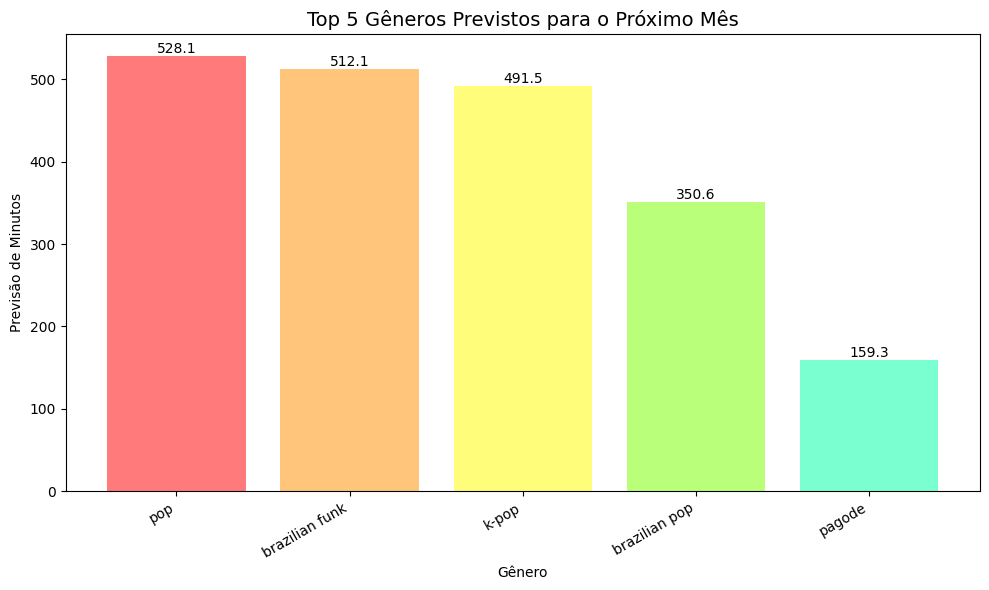

In [222]:
# Visualização
cores = ['#FF7A7A', '#FFC57A', '#FFFD7A', '#BAFF7A', '#7AFFD0']

plt.figure(figsize=(10, 6))
bars = plt.bar(top5['genero'], top5['previsao_minutos'], color=cores)
plt.title('Top 5 Gêneros Previstos para o Próximo Mês', fontsize=14)
plt.xlabel('Gênero')
plt.ylabel('Previsão de Minutos')
plt.xticks(rotation=30, ha='right')

for bar, val in zip(bars, top5['previsao_minutos']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{val:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

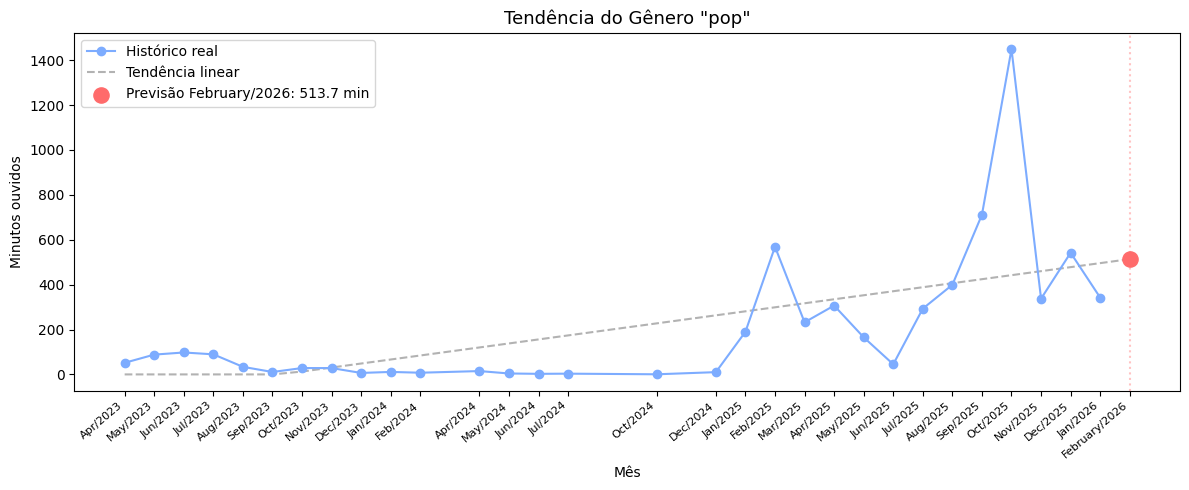

In [ ]:
# Gráfico que mostra a tendência de minutos tocados do gênero previsto
df_v = (
    df_month[df_month['genero'] == genero]
    [['mes_ord', 'mes', 'total_min']]
    .sort_values('mes_ord')
)

model_v = LinearRegression().fit(df_v[['mes_ord']], df_v['total_min'])

# Ponto de previsão
x_fut = np.array([[proximo_mes_ord]])
y_fut = max(model_v.predict(x_fut)[0], 0)

# Labels do eixo x: meses reais do histórico + próximo mês
x_ords  = list(df_v['mes_ord']) + [proximo_mes_ord]
x_labels = [mes_map.get(o, '') for o in df_v['mes_ord']] + [proximo_mes_label]

# Linha de tendência sobre todo o intervalo
x_range = np.arange(df_v['mes_ord'].min(), proximo_mes_ord + 1).reshape(-1, 1)
y_trend = np.clip(model_v.predict(x_range), 0, None)

fig, ax = plt.subplots(figsize=(12, 5))

# Histórico
ax.plot(df_v['mes_ord'], df_v['total_min'], 'o-', label='Histórico real', color='#7DACFF', zorder=3)
# Tendência
ax.plot(x_range, y_trend, '--', label='Tendência linear', color='gray', alpha=0.6)
# Previsão
ax.scatter([proximo_mes_ord], [y_fut], color='#FF6B6B', zorder=5, s=120,
           label=f'Previsão {proximo_mes_label}: {y_fut:.1f} min')

# Eixo x com meses reais — apenas os pontos que existem
ax.set_xticks(x_ords)
ax.set_xticklabels(x_labels, rotation=40, ha='right', fontsize=8)

# Destaque visual para o ponto previsto
ax.axvline(proximo_mes_ord, color='#FF6B6B', linestyle=':', alpha=0.4)

ax.set_title(f'Tendência do Gênero "{genero}"', fontsize=13)
ax.set_xlabel('Mês')
ax.set_ylabel('Minutos ouvidos')
ax.legend()
plt.tight_layout()
plt.show()
